In [26]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [27]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [28]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [29]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [30]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [31]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print('Norm complete')

Norm complete


In [32]:
print(torch.min(nback_p_t[:,420:422],dim=0))
print(torch.min(emoid_p_t[:,420:422],dim=0))

torch.return_types.min(
values=tensor([-2.2998, -3.0133], device='cuda:0'),
indices=tensor([603, 350], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7284, -3.0616], device='cuda:0'),
indices=tensor([351,  33], device='cuda:0'))


In [33]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [34]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [35]:
import torch.nn as nn
import torch.nn.functional as F
import time

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class LatSim(nn.Module):
    def __init__(self, nTgts, inp, dp=0, edp=0.1):
        super(LatSim, self).__init__()
        self.active = nn.Parameter(1e-4*torch.randn(nTgts,inp.shape[-1],2).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
    
    def getLatentsAndEdges(self, x, i):
        e = 1e-10
        y = torch.einsum('ac,ce->ae', x, self.active[i])
        e = e+y@y.T
        return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        res = []
        es = []
        x = self.dp(x)
        for i in range(self.active.shape[0]):
            _, _, e = self.getLatentsAndEdges(x[:,i,:], i)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.edp(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e, dim=1)
            es.append(e)
            res.append(e@y)
        return res, es

def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss
        
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

print('Complete')

Complete


In [128]:
import random

topRegions = np.zeros((10,10,2,5,2)) # Group, N, para, top5, {index, value}
topRMSE = np.zeros((10,10,3)) # Group, N, {train, val, test}

for grp in range(10):
    trainIdcs = groups[grp][0][0:496]
    validIdcs = groups[grp][0]
    testIdcs = groups[grp][1]
    
    for n in range(10):
        if n == 0:
            varArr = wrt_t[trainIdcs]
            varArr = [varArr, varArr]
            regs = [[], []]
        else:
            varArr = [ynback, yemoid]

        for i,var in enumerate(varArr):
            idcs = torch.argsort(var)
            mat = torch.cdist(var[idcs].unsqueeze(1), var[idcs].unsqueeze(1))
            mat = torch.mean(mat) - mat
            
            step = 200
            Y = [nback_p_t[trainIdcs][idcs], emoid_p_t[trainIdcs][idcs]][i]

            parts = []
            for j in range(0,40000,step):
                if j >= Y.shape[1]:
                    break
                part = Y[:,j:j+step]
                corrSim = torch.einsum('ab,db->adb', part, part)
                corr2 = torch.einsum('adb,ad->b', corrSim, mat)
                parts.append(corr2.detach().cpu().numpy())

            parts = np.concatenate(parts)
            idcs = np.argsort(parts)
            
#             idcs = selectSome(idcs, topRegions[grp,:,i,0,0].flatten(), 5)
            idcs = selectSome(idcs, np.concatenate([topRegions[grp,:,i,0,0].flatten(), top10[i]]), 5)
            regs[i] += [idx for idx in idcs[:5]]
            topRegions[grp,n,i,:,0] = idcs[:5]
            topRegions[grp,n,i,:,1] = parts[idcs[:5]]
#             r = None
#             count = 0
#             while r is None or r in regs[i]:
#                 if count == 1:
#                     break
#                 r = random.randint(0,arith(263)-1)
#                 if r not in regs[i]:
#                     count += 1
#                     regs[i] += [r]
#             topRegions[grp,n,i,4,0] = r
            
        rnback = torch.tensor(regs[0], dtype=int)
        remoid = torch.tensor(regs[1], dtype=int)

        X0 = nback_p_t[:,rnback]
        X1 = emoid_p_t[:,remoid]
        Xreg = torch.stack([X0,X1], dim=1)

        print(rnback)
        print(remoid)

        nEpochs = 5000
        pPeriod = 200
        thresh = 100

        sim = LatSim(2, Xreg, 0.5, 0.2) # 0.2 wrat, 0.1 other
        optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4) 

        Xt = Xreg[trainIdcs]
        Xv = Xreg[validIdcs]

        trainLoss = []
        validLoss = []

        vIdcs1 = np.arange(496,len(validIdcs))
        vIdcs2 = validIdcs[496:]
        vIdcs3 = np.concatenate([testIdcs, vIdcs2])

        var = wrt_t

        for epoch in range(nEpochs):
            optim.zero_grad()
            res, _ = sim(Xt, var[trainIdcs])
            avg = torch.mean(torch.stack(res), dim=0)
            loss = 0
            for r in res + [avg]:
                loss += mseLoss(r, var[trainIdcs])
            loss = torch.stack([loss/(len(res)+1)])
            torch.sum(loss).backward()
            optim.step()
            if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
                print(f'epoch {epoch} loss={(float(loss))}')
                lossV = validate(sim, Xv, var[validIdcs], vIdcs1)
                if len(validLoss) == 0 or lossV < min(validLoss):
                    print(f'New best validation epoch {epoch} loss={lossV}')
                    topRMSE[grp,n,1] = lossV
                    torch.save(sim.state_dict(), '../../Work/LatentSim/sim.pyt')
                validLoss.append(lossV)
                if torch.all(loss[0:3] < thresh):
                    print('Early stopping')
                    break
        
        topRMSE[grp,n,0] = torch.sum(loss).detach().cpu().numpy()
        print('Finished training')

        sim.load_state_dict(torch.load('../../Work/LatentSim/sim.pyt'))
        loss = validate(sim, Xreg, var, testIdcs)
        topRMSE[grp,n,2] = loss
        print(f'FINISHED {grp} {n} {loss}')
        
        ynback = var[trainIdcs]-res[0]
        yemoid = var[trainIdcs]-res[1]
        yavg = var[trainIdcs]-avg

#         r0 = F.one_hot(torch.argmax(res[0], dim=1), 2)
#         r1 = F.one_hot(torch.argmax(res[1], dim=1), 2)
#         ra = F.one_hot(torch.argmax(avg, dim=1), 2)

#         ynback = var[trainIdcs]-r0
#         yemoid = var[trainIdcs]-r1
#         yavg = var[trainIdcs]-ra
        
print('ALL DONE')

tensor([6715, 9030, 9025, 6708, 6712])
tensor([ 1160,  9030,  5292, 10626,  1167])
epoch 0 loss=267.51513671875
New best validation epoch 0 loss=12.045499801635742
epoch 200 loss=266.017578125
New best validation epoch 200 loss=12.034635543823242
epoch 400 loss=263.23431396484375
New best validation epoch 400 loss=11.99848461151123
epoch 600 loss=260.4278869628906
New best validation epoch 600 loss=11.946208953857422
epoch 800 loss=257.7495422363281
New best validation epoch 800 loss=11.902220726013184
epoch 1000 loss=254.4326629638672
New best validation epoch 1000 loss=11.874161720275879
epoch 1200 loss=253.9905242919922
New best validation epoch 1200 loss=11.857236862182617
epoch 1400 loss=256.4788818359375
New best validation epoch 1400 loss=11.84655475616455
epoch 1600 loss=255.51596069335938
New best validation epoch 1600 loss=11.836874961853027
epoch 1800 loss=254.7239990234375
New best validation epoch 1800 loss=11.82974624633789
epoch 2000 loss=255.45066833496094
New best vali

epoch 200 loss=255.10374450683594
New best validation epoch 200 loss=11.923432350158691
epoch 400 loss=227.0555877685547
New best validation epoch 400 loss=11.706305503845215
epoch 600 loss=214.0481414794922
New best validation epoch 600 loss=11.638792991638184
epoch 800 loss=225.33189392089844
New best validation epoch 800 loss=11.618167877197266
epoch 1000 loss=212.7674560546875
New best validation epoch 1000 loss=11.608253479003906
epoch 1200 loss=213.53289794921875
New best validation epoch 1200 loss=11.601897239685059
epoch 1400 loss=208.0714569091797
New best validation epoch 1400 loss=11.591455459594727
epoch 1600 loss=211.3763885498047
New best validation epoch 1600 loss=11.586431503295898
epoch 1800 loss=214.655517578125
New best validation epoch 1800 loss=11.58082389831543
epoch 2000 loss=204.21157836914062
New best validation epoch 2000 loss=11.573877334594727
epoch 2200 loss=216.2638397216797
New best validation epoch 2200 loss=11.572600364685059
epoch 2400 loss=207.9966125

epoch 200 loss=237.9320526123047
New best validation epoch 200 loss=11.70034122467041
epoch 400 loss=197.3648681640625
New best validation epoch 400 loss=11.341662406921387
epoch 600 loss=200.66671752929688
New best validation epoch 600 loss=11.278593063354492
epoch 800 loss=196.87710571289062
New best validation epoch 800 loss=11.249105453491211
epoch 1000 loss=184.5695037841797
New best validation epoch 1000 loss=11.226960182189941
epoch 1200 loss=190.037353515625
New best validation epoch 1200 loss=11.215490341186523
epoch 1400 loss=196.53170776367188
New best validation epoch 1400 loss=11.204118728637695
epoch 1600 loss=182.03579711914062
New best validation epoch 1600 loss=11.200990676879883
epoch 1800 loss=189.27297973632812
epoch 2000 loss=189.85508728027344
New best validation epoch 2000 loss=11.188817024230957
epoch 2200 loss=191.69224548339844
epoch 2400 loss=188.45458984375
epoch 2600 loss=193.55224609375
epoch 2800 loss=199.261474609375
epoch 3000 loss=193.45709228515625
ep

epoch 2400 loss=219.65562438964844
epoch 2600 loss=218.62893676757812
epoch 2800 loss=219.93064880371094
epoch 3000 loss=214.70201110839844
epoch 3200 loss=214.1728515625
epoch 3400 loss=220.0693817138672
epoch 3600 loss=222.50830078125
epoch 3800 loss=216.602783203125
epoch 4000 loss=226.10064697265625
epoch 4200 loss=220.02053833007812
epoch 4400 loss=222.73545837402344
epoch 4600 loss=222.76316833496094
epoch 4800 loss=224.15805053710938
epoch 4999 loss=209.68447875976562
Finished training
FINISHED 1 2 15.47389030456543
tensor([23469, 21858, 21035, 10925,  6715, 22205, 21728, 29047, 22196, 25522,
        26016, 18995,  7166, 23557, 31155,   991,   920, 31120, 11512,  7574])
tensor([10626,  2171,  9030, 11046, 34516, 26322, 18053, 33856, 26213, 26214,
          148, 31367,  1167, 32283, 26940,  6894, 12322, 28895,  5222, 10977])
epoch 0 loss=260.9819030761719
New best validation epoch 0 loss=11.892561912536621
epoch 200 loss=250.132568359375
New best validation epoch 200 loss=11.8005

epoch 3800 loss=188.20321655273438
epoch 4000 loss=189.58395385742188
epoch 4200 loss=186.31710815429688
epoch 4400 loss=187.6835174560547
epoch 4600 loss=191.62237548828125
epoch 4800 loss=184.3370361328125
epoch 4999 loss=186.7119598388672
New best validation epoch 4999 loss=10.89992904663086
Finished training
FINISHED 1 6 15.373400688171387
tensor([23469, 21858, 21035, 10925,  6715, 22205, 21728, 29047, 22196, 25522,
        26016, 18995,  7166, 23557, 31155,   991,   920, 31120, 11512,  7574,
        22790, 21615, 24720, 22798, 18268, 21270, 27310, 21035, 17453, 21219,
         7816, 11300, 13525, 30440, 29136,  5613, 32341, 16890, 31705,   508])
tensor([10626,  2171,  9030, 11046, 34516, 26322, 18053, 33856, 26213, 26214,
          148, 31367,  1167, 32283, 26940,  6894, 12322, 28895,  5222, 10977,
        27555, 29358,  7253, 25405, 15211, 20619, 15885, 28601, 29855, 28178,
         7490, 30470,  5811, 28661, 29650, 18095, 32203, 12505, 29271, 19730])
epoch 0 loss=260.81756591796

epoch 4200 loss=258.4997253417969
epoch 4400 loss=256.8087158203125
epoch 4600 loss=251.88372802734375
New best validation epoch 4600 loss=11.704629898071289
epoch 4800 loss=249.3871307373047
epoch 4999 loss=253.11557006835938
New best validation epoch 4999 loss=11.703339576721191
Finished training
FINISHED 2 0 13.231029510498047
tensor([10626, 31155,   139, 23469, 30976, 19651, 22141, 22779, 16607, 19220])
tensor([ 1167, 10626, 31147, 25274,  1160, 20391, 19550, 29958, 20506,  3192])
epoch 0 loss=270.06298828125
New best validation epoch 0 loss=12.067733764648438
epoch 200 loss=266.56060791015625
New best validation epoch 200 loss=12.03956127166748
epoch 400 loss=258.9329528808594
New best validation epoch 400 loss=11.96567440032959
epoch 600 loss=243.08468627929688
New best validation epoch 600 loss=11.899320602416992
epoch 800 loss=235.9285125732422
New best validation epoch 800 loss=11.856619834899902
epoch 1000 loss=245.8970947265625
New best validation epoch 1000 loss=11.81557178

epoch 200 loss=253.2611541748047
New best validation epoch 200 loss=11.853787422180176
epoch 400 loss=209.08018493652344
New best validation epoch 400 loss=11.439409255981445
epoch 600 loss=205.45980834960938
New best validation epoch 600 loss=11.319504737854004
epoch 800 loss=205.78927612304688
epoch 1000 loss=197.94943237304688
New best validation epoch 1000 loss=11.317416191101074
epoch 1200 loss=202.41905212402344
epoch 1400 loss=202.67428588867188
epoch 1600 loss=205.83163452148438
epoch 1800 loss=192.45591735839844
epoch 2000 loss=202.820068359375
epoch 2200 loss=197.24212646484375
epoch 2400 loss=203.7411346435547
New best validation epoch 2400 loss=11.31435775756836
epoch 2600 loss=200.19015502929688
epoch 2800 loss=214.25115966796875
epoch 3000 loss=191.12295532226562
epoch 3200 loss=195.675537109375
epoch 3400 loss=202.024169921875
epoch 3600 loss=203.14541625976562
epoch 3800 loss=205.61236572265625
epoch 4000 loss=203.52011108398438
epoch 4200 loss=210.8107147216797
epoch 4

epoch 200 loss=234.72726440429688
New best validation epoch 200 loss=11.730265617370605
epoch 400 loss=195.51608276367188
New best validation epoch 400 loss=11.401272773742676
epoch 600 loss=193.747314453125
New best validation epoch 600 loss=11.401183128356934
epoch 800 loss=175.84963989257812
epoch 1000 loss=181.0313720703125
New best validation epoch 1000 loss=11.387483596801758
epoch 1200 loss=180.46878051757812
New best validation epoch 1200 loss=11.38001823425293
epoch 1400 loss=186.34555053710938
epoch 1600 loss=181.2662811279297
epoch 1800 loss=182.44139099121094
New best validation epoch 1800 loss=11.379240989685059
epoch 2000 loss=185.43869018554688
New best validation epoch 2000 loss=11.360414505004883
epoch 2200 loss=176.10415649414062
New best validation epoch 2200 loss=11.357413291931152
epoch 2400 loss=180.41162109375
epoch 2600 loss=178.3839111328125
epoch 2800 loss=189.90782165527344
New best validation epoch 2800 loss=11.354792594909668
epoch 3000 loss=184.75932312011

epoch 800 loss=219.06005859375
New best validation epoch 800 loss=10.776251792907715
epoch 1000 loss=207.61941528320312
New best validation epoch 1000 loss=10.751704216003418
epoch 1200 loss=210.15982055664062
New best validation epoch 1200 loss=10.742693901062012
epoch 1400 loss=214.041015625
New best validation epoch 1400 loss=10.734418869018555
epoch 1600 loss=217.41734313964844
New best validation epoch 1600 loss=10.730623245239258
epoch 1800 loss=217.5375213623047
New best validation epoch 1800 loss=10.718969345092773
epoch 2000 loss=216.36880493164062
epoch 2200 loss=209.51083374023438
epoch 2400 loss=211.32101440429688
epoch 2600 loss=215.1220703125
epoch 2800 loss=207.04293823242188
epoch 3000 loss=211.3331298828125
epoch 3200 loss=210.1439208984375
epoch 3400 loss=207.26693725585938
epoch 3600 loss=206.73629760742188
New best validation epoch 3600 loss=10.712224960327148
epoch 3800 loss=206.56309509277344
epoch 4000 loss=202.65048217773438
epoch 4200 loss=204.75906372070312
ep

epoch 200 loss=231.3610076904297
New best validation epoch 200 loss=11.429043769836426
epoch 400 loss=190.2110595703125
New best validation epoch 400 loss=10.91226863861084
epoch 600 loss=189.37863159179688
New best validation epoch 600 loss=10.838464736938477
epoch 800 loss=189.7554168701172
epoch 1000 loss=182.03671264648438
epoch 1200 loss=185.86865234375
epoch 1400 loss=179.111083984375
epoch 1600 loss=186.63894653320312
epoch 1800 loss=189.17105102539062
epoch 2000 loss=189.61309814453125
epoch 2200 loss=190.5345916748047
epoch 2400 loss=193.54583740234375
epoch 2600 loss=180.51419067382812
epoch 2800 loss=181.30075073242188
epoch 3000 loss=181.63497924804688
epoch 3200 loss=179.48716735839844
epoch 3400 loss=178.7379608154297
epoch 3600 loss=180.50042724609375
epoch 3800 loss=181.01846313476562
epoch 4000 loss=184.38031005859375
epoch 4200 loss=185.56509399414062
epoch 4400 loss=183.366943359375
epoch 4600 loss=196.69180297851562
epoch 4800 loss=187.611083984375
epoch 4999 loss=1

epoch 4200 loss=237.5430908203125
New best validation epoch 4200 loss=11.3722562789917
epoch 4400 loss=234.97021484375
epoch 4600 loss=240.3195037841797
epoch 4800 loss=238.3922576904297
epoch 4999 loss=234.9287109375
Finished training
FINISHED 4 1 14.433076858520508
tensor([ 6715, 23469,  6712,  7162,  6709, 22141, 29047, 22779, 29070,   402,
        21858, 19059, 11024, 18358, 18362])
tensor([10626,  1160, 24294,  2162,  1167, 26056, 21662, 17694, 20518,  3192,
        21515, 11027,  9033,  9022, 11046])
epoch 0 loss=266.3573303222656
New best validation epoch 0 loss=11.583380699157715
epoch 200 loss=257.752197265625
New best validation epoch 200 loss=11.482950210571289
epoch 400 loss=243.97360229492188
New best validation epoch 400 loss=11.22817611694336
epoch 600 loss=227.2648162841797
New best validation epoch 600 loss=11.029740333557129
epoch 800 loss=224.8022918701172
New best validation epoch 800 loss=10.957240104675293
epoch 1000 loss=223.3096160888672
New best validation epoc

epoch 1600 loss=204.48287963867188
epoch 1800 loss=190.47250366210938
epoch 2000 loss=195.0983123779297
epoch 2200 loss=189.88900756835938
epoch 2400 loss=185.84500122070312
epoch 2600 loss=188.05453491210938
epoch 2800 loss=185.10067749023438
epoch 3000 loss=197.3973846435547
epoch 3200 loss=185.72134399414062
epoch 3400 loss=192.072998046875
epoch 3600 loss=196.53250122070312
epoch 3800 loss=187.4012451171875
epoch 4000 loss=189.4097900390625
epoch 4200 loss=188.6112060546875
epoch 4400 loss=205.64810180664062
epoch 4600 loss=206.7259979248047
epoch 4800 loss=193.41073608398438
epoch 4999 loss=184.6665496826172
Finished training
FINISHED 4 6 14.61138916015625
tensor([ 6715, 23469,  6712,  7162,  6709, 22141, 29047, 22779, 29070,   402,
        21858, 19059, 11024, 18358, 18362, 23445,   172,  5613, 30352,  6803,
         2150,  2316, 20022,  9102,  1078, 30129, 22798, 20620,   368, 20641,
         9606,  7816, 25928, 26475, 11685, 11923, 10869, 24493, 10885,  3300])
tensor([10626,  1

epoch 200 loss=257.9056091308594
New best validation epoch 200 loss=12.092960357666016
epoch 400 loss=249.3880615234375
New best validation epoch 400 loss=11.958664894104004
epoch 600 loss=240.06918334960938
New best validation epoch 600 loss=11.784468650817871
epoch 800 loss=234.3607177734375
New best validation epoch 800 loss=11.632088661193848
epoch 1000 loss=229.1780242919922
New best validation epoch 1000 loss=11.532560348510742
epoch 1200 loss=230.40145874023438
New best validation epoch 1200 loss=11.47875690460205
epoch 1400 loss=219.19464111328125
New best validation epoch 1400 loss=11.444382667541504
epoch 1600 loss=222.24130249023438
New best validation epoch 1600 loss=11.422389030456543
epoch 1800 loss=224.5358123779297
New best validation epoch 1800 loss=11.415264129638672
epoch 2000 loss=228.70614624023438
New best validation epoch 2000 loss=11.410571098327637
epoch 2200 loss=235.125
New best validation epoch 2200 loss=11.404376983642578
epoch 2400 loss=232.44158935546875


epoch 200 loss=242.7034149169922
New best validation epoch 200 loss=11.988259315490723
epoch 400 loss=215.4158172607422
New best validation epoch 400 loss=11.692062377929688
epoch 600 loss=204.96493530273438
New best validation epoch 600 loss=11.542983055114746
epoch 800 loss=201.63864135742188
New best validation epoch 800 loss=11.497720718383789
epoch 1000 loss=199.37460327148438
New best validation epoch 1000 loss=11.471295356750488
epoch 1200 loss=204.4304656982422
epoch 1400 loss=192.89646911621094
New best validation epoch 1400 loss=11.46910285949707
epoch 1600 loss=202.22537231445312
New best validation epoch 1600 loss=11.46583366394043
epoch 1800 loss=201.79330444335938
New best validation epoch 1800 loss=11.462637901306152
epoch 2000 loss=199.31072998046875
epoch 2200 loss=213.23443603515625
New best validation epoch 2200 loss=11.460257530212402
epoch 2400 loss=192.2509765625
New best validation epoch 2400 loss=11.45875358581543
epoch 2600 loss=195.13687133789062
epoch 2800 lo

epoch 200 loss=226.2601776123047
New best validation epoch 200 loss=11.883856773376465
epoch 400 loss=183.6967010498047
New best validation epoch 400 loss=11.704845428466797
epoch 600 loss=183.41770935058594
New best validation epoch 600 loss=11.672788619995117
epoch 800 loss=178.0867156982422
New best validation epoch 800 loss=11.659421920776367
epoch 1000 loss=186.94802856445312
New best validation epoch 1000 loss=11.655220031738281
epoch 1200 loss=170.0222930908203
New best validation epoch 1200 loss=11.64910888671875
epoch 1400 loss=184.69558715820312
New best validation epoch 1400 loss=11.647520065307617
epoch 1600 loss=184.45811462402344
epoch 1800 loss=191.73501586914062
epoch 2000 loss=176.0986785888672
epoch 2200 loss=180.67529296875
epoch 2400 loss=178.2441864013672
epoch 2600 loss=181.03500366210938
epoch 2800 loss=170.76327514648438
epoch 3000 loss=185.3330535888672
epoch 3200 loss=181.06170654296875
epoch 3400 loss=183.5664520263672
epoch 3600 loss=178.189453125
epoch 3800

epoch 200 loss=238.5277557373047
New best validation epoch 200 loss=12.856971740722656
epoch 400 loss=214.55918884277344
New best validation epoch 400 loss=12.481410026550293
epoch 600 loss=198.84661865234375
New best validation epoch 600 loss=12.277554512023926
epoch 800 loss=204.73704528808594
New best validation epoch 800 loss=12.228471755981445
epoch 1000 loss=198.39044189453125
New best validation epoch 1000 loss=12.221800804138184
epoch 1200 loss=198.30447387695312
New best validation epoch 1200 loss=12.218193054199219
epoch 1400 loss=199.14633178710938
New best validation epoch 1400 loss=12.213658332824707
epoch 1600 loss=196.0362548828125
New best validation epoch 1600 loss=12.212507247924805
epoch 1800 loss=201.15545654296875
epoch 2000 loss=194.10467529296875
epoch 2200 loss=201.94052124023438
epoch 2400 loss=198.552001953125
epoch 2600 loss=205.60179138183594
epoch 2800 loss=193.35162353515625
epoch 3000 loss=196.65081787109375
epoch 3200 loss=204.27713012695312
epoch 3400 l

epoch 1000 loss=181.07943725585938
epoch 1200 loss=171.8407440185547
epoch 1400 loss=178.91744995117188
epoch 1600 loss=185.32162475585938
epoch 1800 loss=189.38177490234375
epoch 2000 loss=183.5261688232422
epoch 2200 loss=173.18551635742188
epoch 2400 loss=172.18186950683594
epoch 2600 loss=181.3551025390625
epoch 2800 loss=181.6519012451172
epoch 3000 loss=169.21873474121094
epoch 3200 loss=171.19369506835938
epoch 3400 loss=178.5149383544922
epoch 3600 loss=179.56130981445312
epoch 3800 loss=171.42532348632812
epoch 4000 loss=182.92852783203125
epoch 4200 loss=173.73992919921875
epoch 4400 loss=175.66650390625
epoch 4600 loss=179.52297973632812
epoch 4800 loss=173.71835327148438
epoch 4999 loss=180.72412109375
Finished training
FINISHED 6 8 16.81240463256836
tensor([24150,  9045,  7139,  7179,  9030, 29120, 29070, 29047, 27153, 27059,
        22798, 10885, 22018, 18975, 26016, 24752, 24746, 29136,  5091,   331,
        14612, 17961, 23002, 17977, 16194, 21035, 14615, 29575,   991, 

epoch 200 loss=244.41314697265625
New best validation epoch 200 loss=11.938530921936035
epoch 400 loss=225.69720458984375
New best validation epoch 400 loss=11.82094669342041
epoch 600 loss=219.6455535888672
epoch 800 loss=209.79002380371094
epoch 1000 loss=213.84234619140625
epoch 1200 loss=211.70164489746094
epoch 1400 loss=211.75633239746094
epoch 1600 loss=202.54771423339844
epoch 1800 loss=205.65573120117188
epoch 2000 loss=205.49014282226562
epoch 2200 loss=206.79147338867188
epoch 2400 loss=207.200439453125
epoch 2600 loss=215.48251342773438
epoch 2800 loss=209.37266540527344
epoch 3000 loss=203.9722137451172
epoch 3200 loss=213.2772216796875
epoch 3400 loss=211.74404907226562
epoch 3600 loss=215.4832763671875
epoch 3800 loss=214.85595703125
epoch 4000 loss=205.0723876953125
epoch 4200 loss=209.1781463623047
epoch 4400 loss=206.9588623046875
epoch 4600 loss=203.4028778076172
epoch 4800 loss=203.17697143554688
epoch 4999 loss=210.126708984375
Finished training
FINISHED 7 3 16.158

epoch 200 loss=223.82518005371094
New best validation epoch 200 loss=11.848085403442383
epoch 400 loss=192.8459930419922
New best validation epoch 400 loss=11.806303024291992
epoch 600 loss=179.26657104492188
epoch 800 loss=183.2635955810547
epoch 1000 loss=178.51580810546875
epoch 1200 loss=187.29891967773438
epoch 1400 loss=167.07313537597656
epoch 1600 loss=173.19981384277344
epoch 1800 loss=180.3763427734375
epoch 2000 loss=174.176025390625
epoch 2200 loss=175.85629272460938
epoch 2400 loss=183.8286590576172
epoch 2600 loss=182.00022888183594
epoch 2800 loss=173.12908935546875
epoch 3000 loss=180.5137939453125
epoch 3200 loss=178.5485076904297
epoch 3400 loss=180.527099609375
epoch 3600 loss=176.59091186523438
epoch 3800 loss=182.09396362304688
epoch 4000 loss=181.279296875
epoch 4200 loss=187.8614501953125
epoch 4400 loss=185.7734375
epoch 4600 loss=177.88534545898438
epoch 4800 loss=174.60354614257812
epoch 4999 loss=172.61917114257812
Finished training
FINISHED 7 8 16.1022090911

epoch 200 loss=248.0531005859375
New best validation epoch 200 loss=11.8425931930542
epoch 400 loss=224.98788452148438
New best validation epoch 400 loss=11.531442642211914
epoch 600 loss=216.36871337890625
New best validation epoch 600 loss=11.30679988861084
epoch 800 loss=206.62217712402344
New best validation epoch 800 loss=11.22919750213623
epoch 1000 loss=214.89013671875
New best validation epoch 1000 loss=11.211294174194336
epoch 1200 loss=196.04052734375
New best validation epoch 1200 loss=11.20471477508545
epoch 1400 loss=196.8184051513672
New best validation epoch 1400 loss=11.197771072387695
epoch 1600 loss=209.23936462402344
New best validation epoch 1600 loss=11.189361572265625
epoch 1800 loss=207.13165283203125
New best validation epoch 1800 loss=11.180630683898926
epoch 2000 loss=210.91561889648438
epoch 2200 loss=204.5506591796875
epoch 2400 loss=216.8360595703125
epoch 2600 loss=208.76068115234375
New best validation epoch 2600 loss=11.178951263427734
epoch 2800 loss=20

epoch 200 loss=233.6573486328125
New best validation epoch 200 loss=11.585792541503906
epoch 400 loss=195.7008056640625
New best validation epoch 400 loss=11.060441017150879
epoch 600 loss=195.83782958984375
New best validation epoch 600 loss=10.92909049987793
epoch 800 loss=186.63601684570312
New best validation epoch 800 loss=10.89852523803711
epoch 1000 loss=193.49948120117188
New best validation epoch 1000 loss=10.88775634765625
epoch 1200 loss=187.24533081054688
New best validation epoch 1200 loss=10.880043029785156
epoch 1400 loss=188.86428833007812
epoch 1600 loss=190.77670288085938
epoch 1800 loss=195.23464965820312
epoch 2000 loss=190.8074951171875
New best validation epoch 2000 loss=10.87102222442627
epoch 2200 loss=178.42593383789062
epoch 2400 loss=187.12060546875
New best validation epoch 2400 loss=10.870783805847168
epoch 2600 loss=189.17269897460938
epoch 2800 loss=184.97659301757812
epoch 3000 loss=190.0190887451172
epoch 3200 loss=188.71331787109375
epoch 3400 loss=178

epoch 1000 loss=228.4840545654297
New best validation epoch 1000 loss=11.8819580078125
epoch 1200 loss=222.27972412109375
New best validation epoch 1200 loss=11.842070579528809
epoch 1400 loss=227.6343994140625
New best validation epoch 1400 loss=11.820513725280762
epoch 1600 loss=231.6294403076172
New best validation epoch 1600 loss=11.802450180053711
epoch 1800 loss=226.4124755859375
New best validation epoch 1800 loss=11.786818504333496
epoch 2000 loss=228.27362060546875
New best validation epoch 2000 loss=11.775635719299316
epoch 2200 loss=224.88580322265625
New best validation epoch 2200 loss=11.77078914642334
epoch 2400 loss=228.44137573242188
New best validation epoch 2400 loss=11.765636444091797
epoch 2600 loss=232.54727172851562
New best validation epoch 2600 loss=11.762094497680664
epoch 2800 loss=224.5563201904297
New best validation epoch 2800 loss=11.756467819213867
epoch 3000 loss=234.4398193359375
epoch 3200 loss=226.56259155273438
epoch 3400 loss=230.5027313232422
New b

epoch 1000 loss=196.6074676513672
New best validation epoch 1000 loss=11.477951049804688
epoch 1200 loss=191.080810546875
New best validation epoch 1200 loss=11.464021682739258
epoch 1400 loss=190.1248016357422
New best validation epoch 1400 loss=11.45648193359375
epoch 1600 loss=189.5204315185547
epoch 1800 loss=199.6747283935547
epoch 2000 loss=186.25241088867188
epoch 2200 loss=197.01718139648438
epoch 2400 loss=189.42288208007812
epoch 2600 loss=190.52102661132812
New best validation epoch 2600 loss=11.44882583618164
epoch 2800 loss=187.37173461914062
epoch 3000 loss=203.82864379882812
epoch 3200 loss=193.92306518554688
epoch 3400 loss=192.29978942871094
epoch 3600 loss=186.83641052246094
epoch 3800 loss=195.7820281982422
epoch 4000 loss=199.2202606201172
New best validation epoch 4000 loss=11.4481782913208
epoch 4200 loss=206.79954528808594
New best validation epoch 4200 loss=11.446508407592773
epoch 4400 loss=192.2963104248047
epoch 4600 loss=194.98468017578125
epoch 4800 loss=19

epoch 800 loss=176.1239013671875
epoch 1000 loss=176.7345428466797
epoch 1200 loss=168.77638244628906
epoch 1400 loss=175.74093627929688
New best validation epoch 1400 loss=11.485796928405762
epoch 1600 loss=177.91424560546875
epoch 1800 loss=177.60797119140625
New best validation epoch 1800 loss=11.481185913085938
epoch 2000 loss=178.95947265625
epoch 2200 loss=177.913818359375
epoch 2400 loss=169.84153747558594
epoch 2600 loss=177.71893310546875
epoch 2800 loss=183.9095458984375
epoch 3000 loss=177.60198974609375
epoch 3200 loss=172.5597381591797
epoch 3400 loss=166.29017639160156
epoch 3600 loss=176.08236694335938
epoch 3800 loss=169.58804321289062
epoch 4000 loss=183.30255126953125
epoch 4200 loss=183.383056640625
epoch 4400 loss=171.6507568359375
epoch 4600 loss=183.5623779296875
epoch 4800 loss=174.0502166748047
epoch 4999 loss=177.37149047851562
Finished training
FINISHED 9 9 16.578147888183594
ALL DONE


In [121]:
print(np.mean(topRMSE[:,:,2], axis=0))

[15.70978012 15.66539612 15.62388382 15.66486616 15.63380299 15.59614716
 15.54709339 15.66043367 15.53754911 15.60063553]


/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


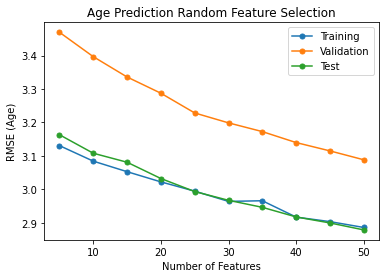

In [46]:
import matplotlib.pyplot as plt

train = (np.sum(topRMSE[:,:,0], axis=0)/10)**0.5/12
bestVal = np.sum(topRMSE[:,:,1], axis=0)/10/12
testNoVal = np.sum(topRMSE[:,:,2], axis=0)/10/12

idcs = 5*np.arange(1,11)

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(idcs, train, label='Training', marker='.', markersize=10)
ax.plot(idcs, bestVal, label='Validation', marker='.', markersize=10)
ax.plot(idcs, testNoVal, label='Test', marker='.', markersize=10)

ax.legend()
ax.set_title('Age Prediction Random Feature Selection')
ax.set_xlabel('Number of Features')
ax.set_ylabel('RMSE (Age)')

fig.show()
fig.savefig('../../Work/LatentSim/RandomValidation50FeatDP5DP2.png', format='png', bbox_inches='tight')

In [129]:
with open('../../Work/LatentSim/Greed/WratValidation2ndBest50FeatDP5DP2.pkl', 'wb') as f:
    pickle.dump([topRegions, topRMSE], f)
    
print('Complete')

Complete


In [45]:
allReg = topRegions[:,0:3,:,4,0].flatten()

print(len(allReg))
print(len(np.unique(allReg)))

60
16


In [125]:
import pickle

with open('../../Work/LatentSim/Greed/WratValidationDP2.pkl', 'rb') as f:
    topRegionsBest, topRMSEBest = pickle.load(f)
    
print(topRMSEBest.shape)

(10, 10, 3)


In [126]:
import numpy as np

top10nback = np.unique(topRegionsBest[:,:,0,:,0].flatten())
top10emoid = np.unique(topRegionsBest[:,:,1,:,0].flatten())

top10 = [top10nback, top10emoid]

print(top10)

[array([  106.,   192.,   238.,   286.,   291.,   292.,   329.,   498.,
         745.,   902.,   905.,  1136.,  1258.,  2005.,  2162.,  2651.,
        2912.,  3006.,  3126.,  3241.,  3855.,  3861.,  3892.,  4052.,
        4055.,  4234.,  4243.,  4744.,  4759.,  5127.,  5292.,  6313.,
        6320.,  6390.,  6413.,  6611.,  6624.,  6695.,  6726.,  6727.,
        7083.,  7152.,  7165.,  7207.,  7214.,  7253.,  7461.,  7569.,
        7585.,  7650.,  7653.,  7666.,  7667.,  7913.,  8817.,  9024.,
        9081.,  9339.,  9719.,  9966., 10084., 10407., 10587., 11022.,
       11030., 11041., 11296., 11699., 11911., 12279., 12547., 13508.,
       15007., 15014., 15684., 15701., 16088., 16601., 16602., 16706.,
       16760., 17031., 17099., 17330., 17331., 17364., 17377., 17388.,
       17431., 17442., 17454., 17474., 17485., 17487., 17488., 18049.,
       18075., 18382., 18523., 18825., 18835., 19017., 19060., 19070.,
       19145., 19159., 19302., 19342., 19663., 19683., 19708., 19730.,
     

In [87]:
flt = topRegionsBest[:,:,0,:,0].flatten()
print(flt)
print(top10nback)
print(top10emoid)
print(select1(flt, top10nback))
print(select1(flt, top10emoid))

[1.8108e+04 3.4569e+04 1.5707e+04 8.3950e+03 1.5628e+04 9.3070e+03
 3.7970e+03 4.1260e+03 4.1250e+03 2.2652e+04 1.9790e+03 1.9650e+03
 1.8229e+04 2.0070e+03 1.9640e+03 1.6126e+04 3.4641e+04 1.3537e+04
 2.2714e+04 3.1933e+04 2.2714e+04 1.7460e+03 1.3423e+04 2.9602e+04
 1.7261e+04 1.8249e+04 1.8270e+04 2.7080e+03 1.8296e+04 1.3300e+02
 1.8260e+04 3.0060e+04 2.9769e+04 1.7380e+03 1.4190e+03 2.1128e+04
 3.2208e+04 2.1163e+04 3.2999e+04 1.4350e+03 1.4391e+04 2.9961e+04
 1.5702e+04 1.9165e+04 2.4887e+04 2.7117e+04 3.2999e+04 4.2900e+02
 2.9769e+04 2.3132e+04 6.4600e+02 2.2868e+04 1.1757e+04 2.0851e+04
 1.0076e+04 6.7800e+02 7.1500e+02 1.6966e+04 2.8503e+04 6.0700e+02
 2.2330e+04 1.6998e+04 5.2700e+02 6.4500e+02 2.2795e+04 7.4700e+02
 9.3290e+03 5.2700e+02 6.4500e+02 2.8140e+03 6.1600e+02 6.4700e+02
 6.4000e+02 6.4500e+02 7.0700e+02 6.1200e+02 6.1100e+02 2.3633e+04
 1.2320e+03 2.2436e+04 2.0736e+04 1.3505e+04 2.0738e+04 1.5886e+04
 2.7959e+04 2.0393e+04 1.9498e+04 2.0994e+04 2.0996e+04 2.0757

In [47]:
def selectSome(idcs, blacklist, n):
    lst = []
    for i in range(-1,-500,-1):
        if idcs[i] not in blacklist:
            lst.append(idcs[i])
            if len(lst) == n:
                return lst
            
selectSome([0, 10372], top10[1], 1)

[0]